GloVe

* GloVe (https://nlpython.com/implementing-glove-model-with-pytorch/)

In [1]:
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE


cuda_available = torch.cuda.is_available()

In [2]:
class GloveDataset:
    
    def __init__(self, data_file_path, window_size = 2):
        with open(data_file_path,'r',encoding='utf-8') as f:
            text = f.read().lower()
        
        self._window_size = window_size
        
        #self._tokens = word_tokenize(text)
        
        self._tokens = text.split(" ")
        word_counter = Counter()
        word_counter.update(self._tokens)
        self._word2id = {w:i for i, (w,_) in enumerate(word_counter.most_common())}
        self._id2word = {i:w for w, i in self._word2id.items()}
        self._vocab_len = len(self._word2id)
        
        self._id_tokens = [self._word2id[w] for w in self._tokens]
        
        self._create_coocurrence_matrix()
        
        print("# of words: {}".format(len(self._tokens)))
        print("Vocabulary length: {}".format(self._vocab_len))
        
    def _create_coocurrence_matrix(self):
        cooc_mat = defaultdict(Counter)
        for i, w in enumerate(self._id_tokens):
            start_i = max(i - self._window_size, 0)
            end_i = min(i + self._window_size + 1, len(self._id_tokens))
            for j in range(start_i, end_i):
                if i != j:
                    c = self._id_tokens[j]
                    cooc_mat[w][c] += 1 / abs(j-i)
                    
        self._i_idx = list()
        self._j_idx = list()
        self._xij = list()
        
        #Create indexes and x values tensors
        for w, cnt in cooc_mat.items():
            for c, v in cnt.items():
                self._i_idx.append(w)
                self._j_idx.append(c)
                self._xij.append(v)
        if cuda_available:
            self._i_idx = torch.LongTensor(self._i_idx).cuda()
            self._j_idx = torch.LongTensor(self._j_idx).cuda()
            self._xij = torch.FloatTensor(self._xij).cuda()
        else:
            self._i_idx = torch.LongTensor(self._i_idx)
            self._j_idx = torch.LongTensor(self._j_idx)
            self._xij = torch.FloatTensor(self._xij)
    
    
    def get_batches(self, batch_size):
        #Generate random idx
        rand_ids = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))
        
        for p in range(0, len(rand_ids), batch_size):
            batch_ids = rand_ids[p:p+batch_size]
            yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]

In [3]:
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)
        
        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()
        
    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()
        
        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j
        
        return x

In [4]:
def weight_func(x, x_max, alpha):
    wx = (x/x_max)**alpha
    wx = torch.min(wx, torch.ones_like(wx))
    if cuda_available:
        return wx.cuda()  
    else:
        return wx


def wmse_loss(weights, inputs, targets):
    loss = weights * F.mse_loss(inputs, targets, reduction='none')
    if cuda_available:
        return torch.mean(loss).cuda()
    else:
        return torch.mean(loss)

In [6]:
from google.colab import drive
drive.mount('/content/drive')
#replace the following path according to your Google Drive path
#%cd/gdrive/My Drive/Monash-FIT-S1-2022/Basic-CYK-Parser
folder_path = "/content/drive/MyDrive/Monash-FIT-S1-2023/week9"

Mounted at /content/drive


# of words: 204469
Vocabulary length: 29266
Epoch: 1/10 	 Batch: 100/916 	 Loss: 0.19074266403913498
Epoch: 1/10 	 Batch: 200/916 	 Loss: 0.181365405023098
Epoch: 1/10 	 Batch: 300/916 	 Loss: 0.162039477750659
Epoch: 1/10 	 Batch: 400/916 	 Loss: 0.16144214272499086
Epoch: 1/10 	 Batch: 500/916 	 Loss: 0.14328745603561402
Epoch: 1/10 	 Batch: 600/916 	 Loss: 0.13790293745696544
Epoch: 1/10 	 Batch: 700/916 	 Loss: 0.13797342367470264
Epoch: 1/10 	 Batch: 800/916 	 Loss: 0.1431978765875101
Epoch: 1/10 	 Batch: 900/916 	 Loss: 0.12009059973061084
Epoch: 2/10 	 Batch: 100/916 	 Loss: 0.06739500500261783
Epoch: 2/10 	 Batch: 200/916 	 Loss: 0.07323534376919269
Epoch: 2/10 	 Batch: 300/916 	 Loss: 0.07079657893627882
Epoch: 2/10 	 Batch: 400/916 	 Loss: 0.06889334302395582
Epoch: 2/10 	 Batch: 500/916 	 Loss: 0.07034271135926247
Epoch: 2/10 	 Batch: 600/916 	 Loss: 0.06735535841435195
Epoch: 2/10 	 Batch: 700/916 	 Loss: 0.06750845499336719
Epoch: 2/10 	 Batch: 800/916 	 Loss: 0.0620423829

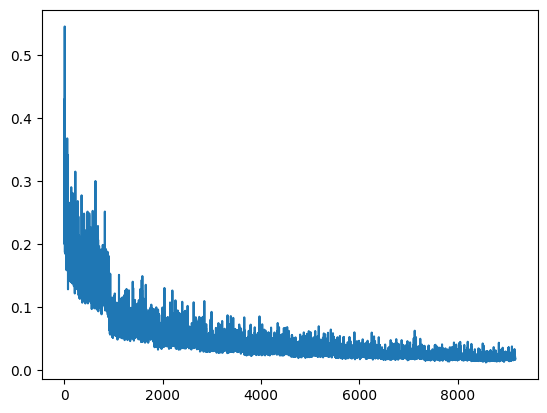

In [7]:
file_path = folder_path + "/corpus/trump_news.txt"
dataset = GloveDataset(file_path)
EMBED_DIM = 50

glove = GloveModel(dataset._vocab_len, EMBED_DIM)

optimizer = optim.Adagrad(glove.parameters(), lr=0.05)

#training
N_EPOCHS = 10
BATCH_SIZE = 500
X_MAX = 100
ALPHA = 0.75
n_batches = int(len(dataset._xij) / BATCH_SIZE)
loss_values = list()
for e in range(1, N_EPOCHS+1):
    batch_i = 0
    
    for x_ij, i_idx, j_idx in dataset.get_batches(BATCH_SIZE):
        
        batch_i += 1
        
        optimizer.zero_grad()
        
        outputs = glove(i_idx, j_idx)
        weights_x = weight_func(x_ij, X_MAX, ALPHA)
        loss = wmse_loss(weights_x, outputs, torch.log(x_ij))
        
        loss.backward()
        
        optimizer.step()
        
        loss_values.append(loss.item())
        
        if batch_i % 100 == 0:
            print("Epoch: {}/{} \t Batch: {}/{} \t Loss: {}".format(e, N_EPOCHS, batch_i, n_batches, np.mean(loss_values[-20:])))      

plt.plot(loss_values)
print("Saving model...")
torch.save(glove.state_dict(), "GloVe.pt")

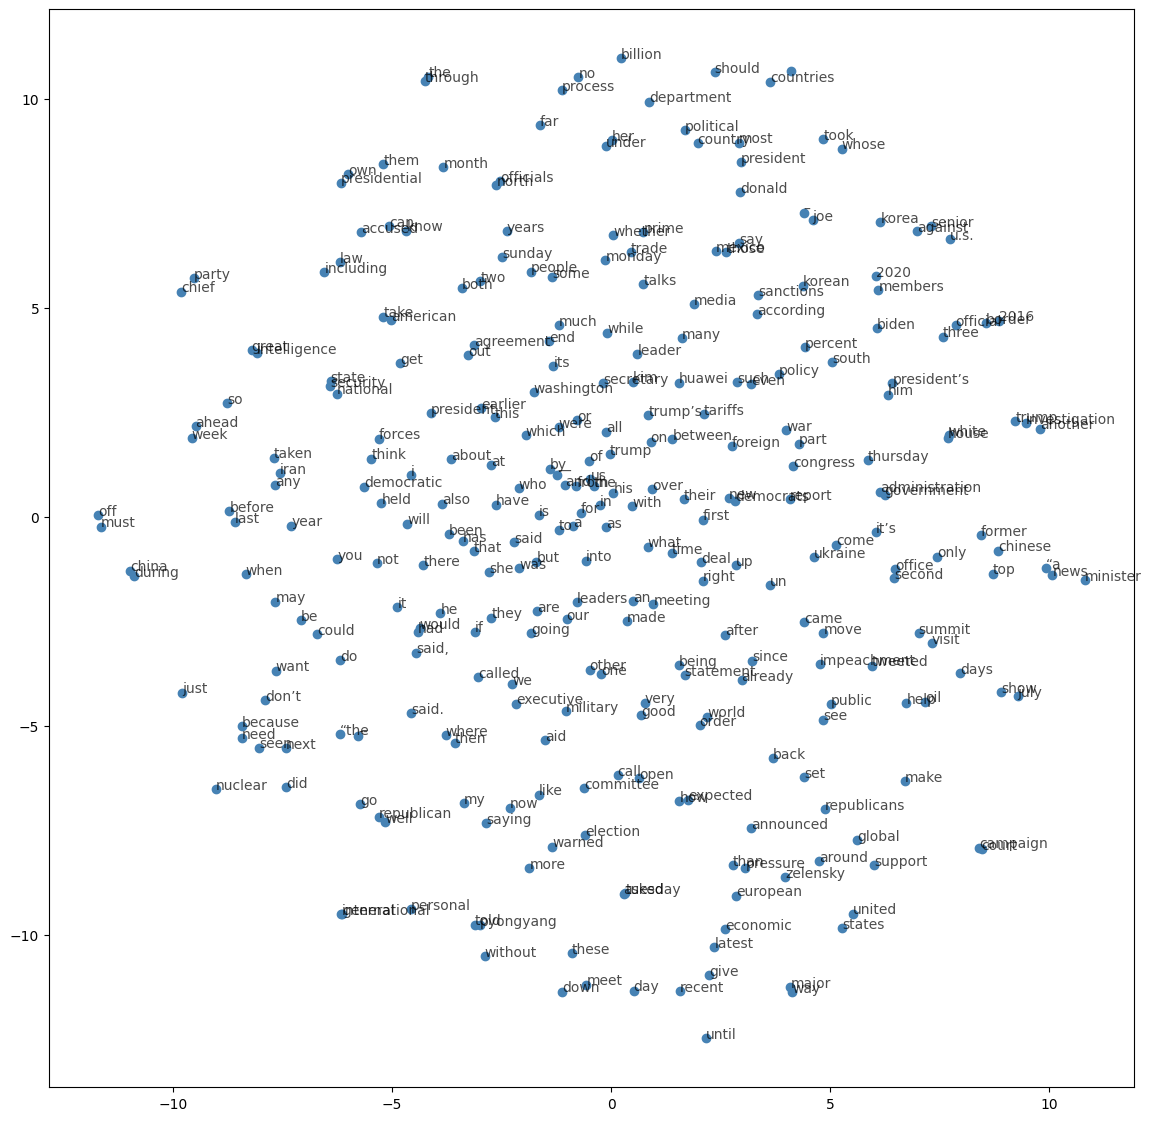

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
emb = emb_i + emb_j
top_k = 300
tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(emb[:top_k, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(dataset._id2word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)